# Amazon Rekognition demonstration

[Amazon Rekognition](https://aws.amazon.com/pt/rekognition/) is a managed service for image recognition. It has several features like: object classification, face detection, image moderation, face recognition, etc. It's main features will be presented in this Notebook.

For more information about the Python API (boto3) used in this demonstration, click:

http://boto3.readthedocs.io/en/latest/reference/services/rekognition.html#Rekognition.Client.detect_labels

In [1]:
# checking the boto3 version
import boto3
if boto3.__version__ < "a1.4.8":
    !conda update --yes boto3
    print("Please, reload your kernel now.")

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.12
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/ec2-user/anaconda3/envs/mxnet_p36

  added / updated specs: 
    - boto3


The following packages will be UPDATED:

    boto3:    1.12.0-py_0       --> 1.12.39-py_0     
    botocore: 1.15.0-py_0       --> 1.15.39-py_0     
    certifi:  2019.11.28-py36_0 --> 2020.4.5.1-py36_0

Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Please, reload your kernel now.


In [2]:
%matplotlib inline

# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython.display as disp

from PIL import Image, ImageDraw
from IPython.display import Markdown

from notebook import notebookapp

In [3]:
## Here we will create the Rekognition client. 
client = boto3.client('rekognition')

dataset_dir="https://spock.cloud/ai-workshop/reko_data.tar.gz"
base_dir="/tmp/reko"

In [4]:
!mkdir -p $base_dir
!curl -s $dataset_dir | tar -xz -C $base_dir
!ln -sf $base_dir/star_wars.mp4 .

## Helper functions

In [5]:
# Reads an image from the disk and coverts it to a bytearray
def load_image(filename):
    with open(filename, "rb") as imageFile:
      f = imageFile.read()
      return bytearray(f)

In [6]:
# Converts an array to a Pandas dataframe
def convert_to_dataframe(labels):
    data = { 'Label': [], 'Confidence': [] }

    for label in labels:
        data['Label'].append( label['Name'] )
        data['Confidence'].append( label['Confidence'] )

    return pd.DataFrame( data )[ ['Label', 'Confidence'] ]

In [7]:
# Invokes Rekognition to extract labels (metadata) from an image
def get_labels(filename):
    response = client.detect_labels(
        Image={'Bytes': load_image(filename)},
        MaxLabels=10,
        MinConfidence=50
    )
    return convert_to_dataframe(response['Labels'])

In [8]:
# Invokes Rekognition to extract moderation labels from an image
def get_moderation_labels(filename):
    response = client.detect_moderation_labels(
        Image={ 'Bytes': load_image(filename) },
        MinConfidence=50
    )
    return convert_to_dataframe(response['ModerationLabels'])

In [9]:
# Converts a bounding box to a rectangle
def create_bounding_box(bbox, size):
    if len(bbox) != 4:
        return None
    return [ 
        bbox['Left'] * size[0], bbox['Top'] * size[1],
        (bbox['Left'] * size[0]) + bbox['Width'] * size[0], 
        (bbox['Top'] * size[1]) + bbox['Height'] * size[1]
    ]

In [10]:
# Invokes Rekognition for recognizing celebrities in an image
def recognize_celebrity(filename):
    response = client.recognize_celebrities(
        Image={'Bytes': load_image(filename)}
    )
    img = Image.open(filename)
    if len(response['CelebrityFaces']) == 0:
        return (None, None, None)
    
    bbox = create_bounding_box( response['CelebrityFaces'][0]['Face']['BoundingBox'], img.size )
    confidence = response['CelebrityFaces'][0]['Face']['Confidence']
    name = response['CelebrityFaces'][0]['Name']
    
    return (name, confidence, bbox )

In [11]:
# Draws a bound box in an image
def draw_bounding_box(filename, bbox):
    img = Image.open(filename)

    draw = ImageDraw.Draw(img)
    draw.line([(bbox[0], bbox[1]), (bbox[2], bbox[1])], fill='yellow', width=4)
    draw.line([(bbox[2], bbox[1]), (bbox[2], bbox[3])], fill='yellow', width=4)
    draw.line([(bbox[2], bbox[3]), (bbox[0], bbox[3])], fill='yellow', width=4)
    draw.line([(bbox[0], bbox[1]), (bbox[0], bbox[3])], fill='yellow', width=4)
    del draw
    plt.imshow(img)

In [12]:
# Detects a face and it's characteristics in a given image
def detect_face(filename):
    response = client.detect_faces(
        Image={'Bytes': load_image(filename)},
        Attributes=['ALL']
    )
    if len(response['FaceDetails']) == 0:
        return None
    img = Image.open(filename)
    metadata = response['FaceDetails'][0]
    confidence = metadata['Confidence']
    bbox = create_bounding_box( metadata['BoundingBox'], img.size )
    labels = []
    for label in ('Smile', 'Eyeglasses', 'Sunglasses', 'Gender', 'Beard', 'Mustache', 'EyesOpen', 'MouthOpen'):
        labels.append( {'Name': label + "({})".format( metadata[label]['Value']), 'Confidence': metadata[label]['Confidence'] } )
    for emo in metadata['Emotions']:
        labels.append( {'Name': emo['Type'], 'Confidence': emo['Confidence'] } )
    return ( confidence, bbox, convert_to_dataframe(labels) )

In [13]:
# Compares similarities between two faces
def compare_faces(filenameA, filenameB):
    response = client.compare_faces(
        SourceImage={'Bytes': load_image( filenameA )},
        TargetImage={'Bytes': load_image( filenameB )}
    )
    if len(response['FaceMatches']) == 0:
        return ( None, None, None)
    imgA = Image.open(filenameA)
    imgB = Image.open(filenameB)
    
    similarity = response['FaceMatches'][0]['Similarity']
    bboxA = create_bounding_box( response['SourceImageFace']['BoundingBox'], imgA.size )
    bboxB = create_bounding_box( response['FaceMatches'][0]['Face']['BoundingBox'], imgB.size )
    return (similarity, bboxA, bboxB )

In [14]:
def delete_collection(name):
    try:
        response = client.delete_collection(
            CollectionId=name
        )
    except Exception as e:
        print("Collection not found")

## Detects scenes and objects - client.detect_labels()

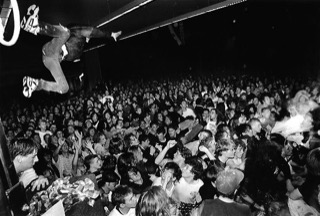

In [15]:
disp.Image(base_dir + '/mosh_thumb.jpg')

In [16]:
get_labels(base_dir + '/mosh.jpg' )

,Label,Confidence
0,Audience,99.611244
1,Crowd,99.611244
2,Person,99.611244
3,Interior Design,94.007942
4,Party,75.050880
5,Leisure Activities,63.334576
6,Club,59.952763
7,Night Life,59.663113
8,Concert,59.018341
9,Rock Concert,56.616318


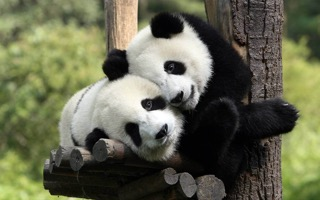

In [17]:
disp.Image(base_dir + '/pandas_thumb.jpg' )

In [18]:
get_labels( base_dir + '/pandas.jpg' )

,Label,Confidence
0,Animal,99.98407
1,Wildlife,99.98407
2,Mammal,99.98407
3,Giant Panda,99.98407
4,Bear,99.98407


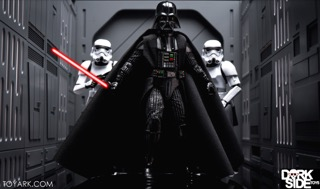

In [19]:
disp.Image(base_dir + '/darth_thumb.jpg' )

In [20]:
get_labels( base_dir + '/darth.jpg' )

,Label,Confidence
0,Clothing,99.569122
1,Helmet,95.227257
2,Person,86.676430
3,Metropolis,71.279556
4,Fashion,65.553276
5,Overcoat,63.099808
6,Cloak,58.576176
7,Long Sleeve,54.993881
8,Evening Dress,53.888393
9,Cape,53.386200


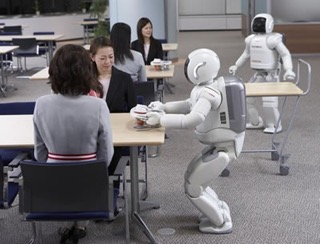

In [21]:
disp.Image(base_dir + '/robots2_thumb.jpg' )

In [22]:
get_labels( base_dir + '/robots2.jpg' )

,Label,Confidence
0,Human,99.833443
1,Person,99.833443
2,Robot,90.185783


## Detects sugestive content + moderation - client.detect_moderation_labels()

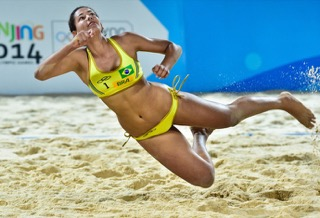

In [23]:
disp.Image(base_dir + '/voley_thumb.jpg' )

In [24]:
get_moderation_labels( base_dir + '/voley.jpg' )

,Label,Confidence
0,Female Swimwear Or Underwear,99.683075
1,Suggestive,99.683075


### Now let's combine moderation with object classification

In [25]:
labels = pd.concat([ get_moderation_labels( base_dir + '/voley.jpg' ), get_labels( base_dir + '/voley.jpg' ) ], ignore_index=True)
labels.sort_values(['Confidence'], ascending=False)

,Label,Confidence
0,Female Swimwear Or Underwear,99.683075
1,Suggestive,99.683075
2,Clothing,97.715225
3,Person,96.610268
4,Swimwear,91.661385
5,Bikini,88.352676
6,Sport,85.124771
7,Female,73.919167
8,Skin,73.052002
9,People,72.291069


## Recognizing celebrities - client.recognize_celebrities()

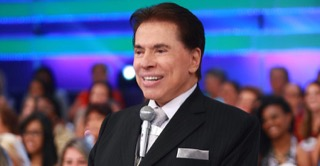

In [26]:
disp.Image(base_dir + '/silvio_thumb.jpg' )

Silvio Santos 99.9999771118164


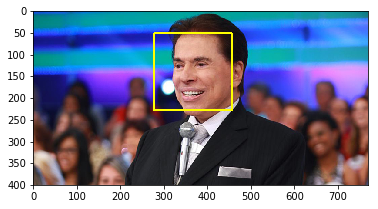

In [27]:
(name, confidence, bbox) = recognize_celebrity( base_dir + '/silvio.jpg' )
print( name, confidence )
draw_bounding_box(base_dir + '/silvio.jpg', bbox )

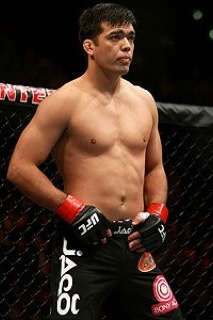

In [28]:
disp.Image(base_dir + '/machida_thumb.jpg' )

Lyoto Machida 99.99999237060547


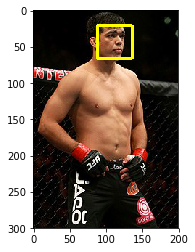

In [29]:
(name, confidence, bbox) = recognize_celebrity( base_dir + '/machida.jpg' )
print( name, confidence )
if bbox: draw_bounding_box(base_dir + '/machida.jpg', bbox )

## Face detection - client.detect_face()

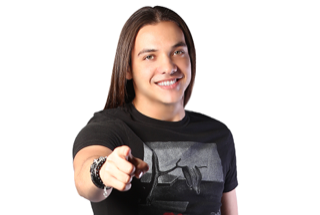

In [30]:
disp.Image(base_dir + '/wesley_thumb.png' )

Confidence that a face was found: 100.0


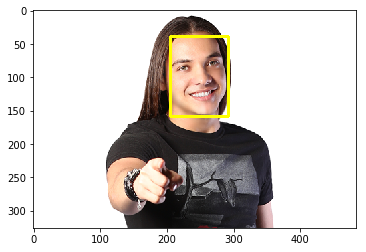

In [31]:
(confidence, bbox, labels) = detect_face( base_dir + '/wesley.png')
print( 'Confidence that a face was found: {}'.format( confidence ) )
if bbox: draw_bounding_box( base_dir + '/wesley.png', bbox )

In [32]:
labels

,Label,Confidence
0,Smile(True),98.809334
1,Eyeglasses(False),97.831573
2,Sunglasses(False),99.254608
3,Gender(Male),76.849556
4,Beard(False),85.910728
5,Mustache(False),98.338203
6,EyesOpen(True),99.007507
7,MouthOpen(True),98.785057
8,DISGUSTED,0.057183
9,FEAR,0.062691


## Comparing two faces - client.compare_faces()

### Source face

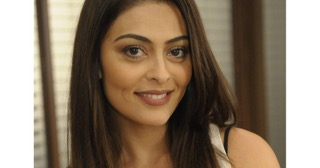

In [33]:
disp.Image(base_dir + '/ju_paes_thumb.jpg' )

### Target faces

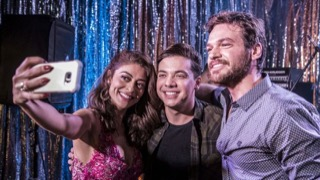

In [34]:
disp.Image(base_dir + '/ju_we_em_thumb.jpg' )

In [35]:
(similarity, bboxA, bboxB) = compare_faces(base_dir + '/ju_paes.jpg', base_dir + '/ju_we_em.jpg')
print( 'Similarity: {}'.format( similarity ) )

Similarity: 99.29058837890625


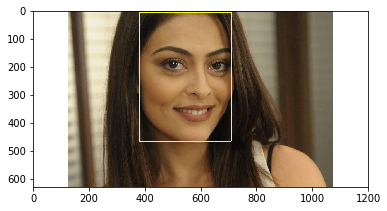

In [36]:
if bboxA: draw_bounding_box(base_dir + '/ju_paes.jpg', bboxA )

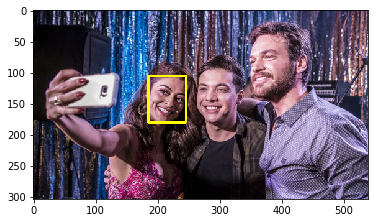

In [37]:
if bboxB: draw_bounding_box(base_dir + '/ju_we_em.jpg', bboxB )

## Searching faces in a collection - client.search_faces()
### Collection ID: Funcionarios
Now let's suppose you have a company and you control who enters and leave the company's building by using face recognition. You keep a collection of authorized faces and check agains that collection if a given person is allowed or not to enter/leave.

In [38]:
try:
    delete_collection("Funcionarios")
    response = client.create_collection(
        CollectionId='Funcionarios'
    )
    faces = {
        'Glenn': base_dir + '/coll_glenn.png',
        'Rick': base_dir + '/coll_rick.jpg',
        'Michonne': base_dir + '/coll_michonne.jpg',
        'Negan': base_dir + '/coll_negan.jpg',
        'Turma': base_dir + '/coll_turma.jpg'
    }
    for ext_id, image_name in faces.items():
        response = client.index_faces(
            CollectionId='Funcionarios',
            Image={ 'Bytes': load_image( image_name ) },
            ExternalImageId=ext_id,
        )
        if len(response['FaceRecords']) > 0:
            for i in response['FaceRecords']:
                print( ext_id, i['Face']['FaceId'])
except Exception as e:
    print(e)

Collection not found
Glenn 077c5482-27be-4aa8-b08d-ec880b8011c6
Rick 6ef235d1-dd54-4a11-b1fa-d37c9e3ab176
Michonne ed760af2-3f1a-43ba-9294-9eaac4824b06
Negan 91de5550-4972-44f1-94cd-2b529de97fb5
Turma 5e66f223-cc16-4b31-938f-1935681ed45d
Turma c80841dc-35d2-404f-a049-ebd4907ae5b5
Turma 765300ad-8aae-450e-9aeb-afa220328bce
Turma ac3f91ac-01cc-4ee7-be70-6740ed9a76cc
Turma bfed7285-4ce6-472c-b6cc-274181087a4d
Turma c1e27ec6-7129-4534-9546-8e3216380b34
Turma e92bf8a4-faa2-48ff-ab9b-6213e689b902
Turma cbd7d8e6-f5fa-4656-8156-5fcecad1fe86


### Ok. Now that our collection is ready, let's see it's content

In [39]:
faces = {}
bboxes = {}
counter = 1
for face in client.list_faces( CollectionId='Funcionarios', MaxResults=20 )['Faces']:
    if faces.get( face['ExternalImageId'] ) == None: 
        faces[ face['ExternalImageId'] ] = []
    faces[ face['ExternalImageId'] ].append( face['FaceId'] )
    bboxes[ face['ExternalImageId'] ] = face['BoundingBox']
    counter += 1

FaceId: 077c5482-27be-4aa8-b08d-ec880b8011c6


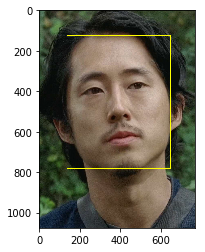

In [40]:
print( "FaceId: {}".format( faces['Glenn'][0] ) )
img = Image.open( base_dir + '/coll_glenn.png' )
draw_bounding_box(base_dir + '/coll_glenn.png', create_bounding_box( bboxes['Glenn'], img.size ) )

FaceId: 6ef235d1-dd54-4a11-b1fa-d37c9e3ab176


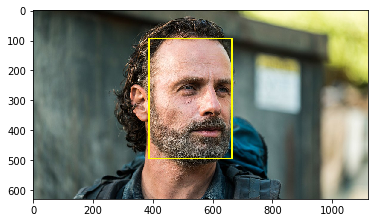

In [41]:
print( "FaceId: {}".format( faces['Rick'][0] ) )
img = Image.open( base_dir + '/coll_rick.jpg' )
draw_bounding_box(base_dir + '/coll_rick.jpg', create_bounding_box( bboxes['Rick'], img.size ) )

FaceId: ed760af2-3f1a-43ba-9294-9eaac4824b06


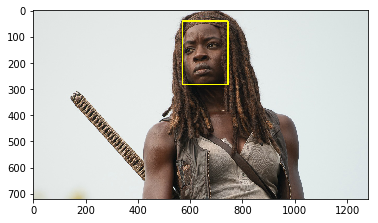

In [42]:
print( "FaceId: {}".format( faces['Michonne'][0] ) )
img = Image.open( base_dir + '/coll_michonne.jpg' )
draw_bounding_box(base_dir + '/coll_michonne.jpg', create_bounding_box( bboxes['Michonne'], img.size ) )

FaceId: 91de5550-4972-44f1-94cd-2b529de97fb5


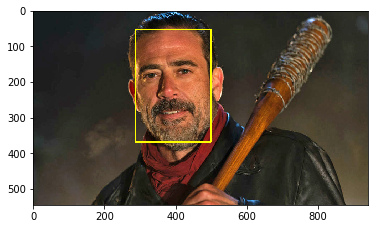

In [43]:
print( "FaceId: {}".format( faces['Negan'][0] ) )
img = Image.open( base_dir + '/coll_negan.jpg' )
draw_bounding_box(base_dir + '/coll_negan.jpg', create_bounding_box( bboxes['Negan'], img.size ) )

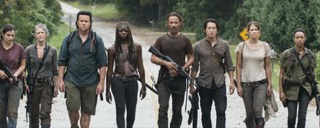

In [44]:
disp.Image(base_dir + '/coll_turma_thumb.jpg' )

In [45]:
face_counter = 1
for faceid in faces['Turma']:
    print( "FaceId{}: {}".format( face_counter, faceid ) )
    face_counter += 1

FaceId1: 5e66f223-cc16-4b31-938f-1935681ed45d
FaceId2: 765300ad-8aae-450e-9aeb-afa220328bce
FaceId3: ac3f91ac-01cc-4ee7-be70-6740ed9a76cc
FaceId4: bfed7285-4ce6-472c-b6cc-274181087a4d
FaceId5: c1e27ec6-7129-4534-9546-8e3216380b34
FaceId6: c80841dc-35d2-404f-a049-ebd4907ae5b5
FaceId7: cbd7d8e6-f5fa-4656-8156-5fcecad1fe86
FaceId8: e92bf8a4-faa2-48ff-ab9b-6213e689b902


### Now, let's search for Michonne in the collection - client.search_faces()

Similarity: 99.6996078491211


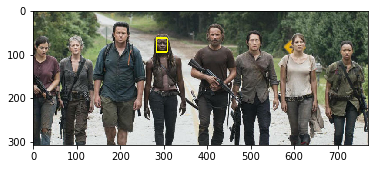

In [46]:
id_michonne = faces['Michonne'][0]
metadata = client.search_faces(
    CollectionId='Funcionarios',
    FaceId=id_michonne,
    MaxFaces=20
)['FaceMatches'][0]
print( 'Similarity: {}'.format( metadata['Similarity'] ) )
img = Image.open( base_dir + '/coll_turma.jpg' )
draw_bounding_box(base_dir + '/coll_turma.jpg', create_bounding_box( metadata['Face']['BoundingBox'], img.size ) )

### Then, let's try to find Glenn by using another picture - client.search_faces_by_image()

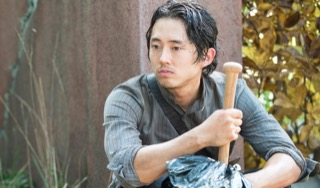

In [47]:
disp.Image(base_dir + '/coll_glenn2_thumb.jpg' )

In [48]:
faces = client.search_faces_by_image(
    CollectionId='Funcionarios',
    Image={ 'Bytes': load_image( base_dir + '/coll_glenn2.jpg') },
    MaxFaces=20
)['FaceMatches']
print( '# Mached faces in the collection: {}'.format( len(faces)))

# Mached faces in the collection: 2


### We found Glenn in which pictures?

Similarity: 99.83393859863281


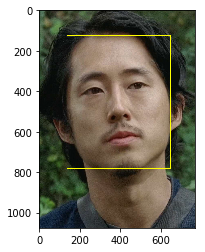

In [49]:
print( 'Similarity: {}'.format( faces[0]['Similarity'] ) )
img = Image.open( base_dir + '/coll_glenn.png' )
draw_bounding_box(base_dir + '/coll_glenn.png', create_bounding_box( faces[0]['Face']['BoundingBox'], img.size ) )

In [ ]:
print( 'Similarity: {}'.format( faces[1]['Similarity'] ) )
img = Image.open( base_dir + '/coll_turma.jpg' )
draw_bounding_box(base_dir + '/coll_turma.jpg', create_bounding_box( faces[1]['Face']['BoundingBox'], img.size ) )

Similarity: 98.0094223022461


### Alright. Now let's see what happens if we use an unknown face (for the collection) for searching

In [ ]:
faces = client.search_faces_by_image(
    CollectionId='Funcionarios',
    Image={ 'Bytes': load_image( base_dir + '/ju_paes.jpg') },
    MaxFaces=20
)['FaceMatches']
print( '# Mached faces in the collection: {}'.format( len(faces)))

# Text in Image client.detect_text()

In [ ]:
disp.Image(base_dir + '/dr_evil.jpg' )

In [ ]:
response = client.detect_text(
    Image={ 'Bytes': load_image( base_dir + '/dr_evil.jpg') },
)
for i in response['TextDetections']:
    print( 'Text[%s] Confidence[%f]' % (i['DetectedText'], i['Confidence']) )

# Video Analysis

Now, right click and 'Save link as' on the following link:
<a href="star_wars.mp4">Star Wars</a><br>
Go to the Rekognition console and upload it to see the new Video Analysis functionality.

# The end :)

In [ ]:
disp.Image(base_dir + '/the_end_thumb.jpg' )

# Clean up

In [ ]:
delete_collection("Funcionarios")

In [ ]:
!rm -rf $base_dir